In [71]:
print(__doc__)

# Code source adapted from: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
import pandas as pd
import os
import csv
import pprint

pp = pprint.PrettyPrinter(indent=4)

Automatically created module for IPython interactive environment


In [72]:
def treat_dataset(dataset):
    vcut = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
    vcolor = {'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0}
    vclarity = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
    
    target = []
    for row in dataset:
        # Modify string to number values
        row["cut"] = vcut[row["cut"]]
        row["color"] = vcolor[row["color"]]
        row["clarity"] = vclarity[row["clarity"]]
        
        # Normalize values
        row["carat"] = (float(row["carat"]) - (0.2+5.01)/2)/(0.2+5.01)
        row["cut"] = (float(row["cut"]) - (4/2))/4
        row["color"] = (float(row["color"]) - (6/2))/6
        row["clarity"] = (float(row["clarity"]) - (7/2))/7
        row["x"] = (float(row["x"]) - (10.74/2))/10.74
        row["y"] = (float(row["y"]) - (58.9/2))/58.9
        row["z"] = (float(row["z"]) - (31.8/2))/31.8
        row["depth"] = (float(row["depth"]) - (43+79)/2)/(43+79)
        row["table"] = (float(row["table"]) - (43+95)/2)/(43+95)
        
        # Add X0 for ease of use
        row["x0"] = 1
        
        # Remove target element and insert into it's own list
        target.append(row["price"])
        del row["price"]
    return target

In [73]:
# Read and treat training dataset
dataset_train = []
reader = csv.DictReader(open('diamonds-train.csv', 'r'))
for line in reader:
     dataset_train.append(line)

target_train = treat_dataset(dataset_train)

# Read and treat test dataset
dataset_test = []
reader = csv.DictReader(open('diamonds-test.csv', 'r'))
for line in reader:
     dataset_test.append(line)

target_test = treat_dataset(dataset_test)

# Auxilary vector for name to number mapping
ds_index = ["x0", "carat", "clarity", "color", "cut", "depth", "table", "x", "y", "z", "price"]

In [74]:
def calculate_cost_function(thetas, data, target):
    m = len(data)
    s = 0
    for index in range(len(data)):
        h = 0
        for k,v in data[index].items():
            h += thetas[k] * data[index][k]
        s += (h - float(target[index]))*(h - float(target[index]))
    return (1/(2*m)) * s

def init_thetas(data):
    if len(data) == 0:
        return {}
    thetas = {}
    for k,v in data[0].items():
        thetas[k] = 0
    return thetas

def plot(x, y, c='black'):
    plt.scatter(x, y, color= c)

    plt.xticks()
    plt.yticks()

    plt.show()

In [146]:
# STOCHASTIC ALGORITHM

# Parameters
# Alpha
learningRate = 1e-04
# Number of cases in training
m = len(dataset_train)
# Thetas Vector
thetas = init_thetas(dataset_train)
# Number of iterations
max_iterations = 1000000
iterations = 0
# After j_step iterations, compute cost function
j_step = 1000
costs = []
itr_numbers = []

# Stop Conditions
stopCondition = 1e-07
done = False

# print(calculate_cost_function(thetas, train_df, target_train_df))

# In the Stochastic mode, the error is calculated using only one row of the data set
# We'll use them one by one 
row = 0
while(iterations < max_iterations and not done):
    
    new_thetas = thetas.copy() 
        
    # For each theta we do the following
    for k1,v1 in thetas.items():
        h = 0
        
        for k2,v2 in thetas.items():
            h += v2 * dataset_train[row][k2]

        # Updating the new thetas vector values
        new_thetas[k1] = v1 - (learningRate * (h - float(target_train[row])) * dataset_train[row][k1])
        
    # Updating row that will be used to calculate the error
    row = (row + 1) % m
    
    if iterations % j_step == 0:
        costs.append(calculate_cost_function(thetas, dataset_train, target_train))
        itr_numbers.append(iterations)
        
    # If the change in value for new thetas is too small, we can stop iterating
    done = True
    for k,v in thetas.items():
        done = abs(thetas[k] - new_thetas[k]) < stopCondition and done    
        
     # Atualization of the values of the thetas
    thetas = new_thetas.copy()
    iterations = iterations + 1
    
if iterations >= max_iterations:
    print("Stopped by number of iterations\n")
if done:
    print("Stopped by convergence\n")

Stopped by convergence



Coefficients: 

{   'carat': 9352.705180320141,
    'clarity': -36.87988940791,
    'color': -606.2900237974865,
    'cut': 329.2060484968358,
    'depth': 2.7980527478802073,
    'table': -309.9689228525515,
    'x': 12698.583965636291,
    'x0': 6521.382358467122,
    'y': -351.79479271347003,
    'z': 45.22047696890871}


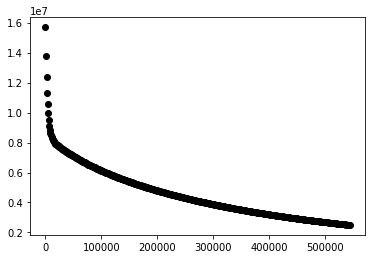

In [147]:
print("Coefficients: \n")
pp.pprint(thetas)

plot(itr_numbers, costs)

In [148]:
# BATCH GRADIENT ALGORITHM

# Parameters
# Alpha
learningRate = 1e-01
# Number of cases in training
m = len(dataset_train)
# Thetas Vector
thetas = init_thetas(dataset_train)
# Number of iterations
max_iterations = 100
iterations = 0
# After j_step iterations, compute cost function
j_step = 10
costs = []
itr_numbers = []
# Stop Conditions
stopCondition = 1e-03
done = False


while(iterations < max_iterations and not done):
    
    new_thetas = thetas.copy()
    
    # For each theta we do the following
    for key,item in thetas.items():
        
        s = 0
        # We add every row of the dataset to the error calculation (Batch)
        for i in range(len(dataset_train)):
            
            h = 0
            # Calculating the value for theta
            for kt,it in thetas.items():
                h += thetas[kt] * dataset_train[i][kt]
                
            s += (h - float(target_train[i])) * dataset_train[i][key]
        
        # Updating the new thetas vector values
        new_thetas[key] = thetas[key] - ((learningRate / m) * s)
    
    if iterations % j_step == 0:
        costs.append(calculate_cost_function(thetas, dataset_train, target_train))
        itr_numbers.append(iterations)
    
    # If the change in value for new thetas is too small, we can stop iterating
    done = True
    for k,v in thetas.items():
        done = abs(thetas[k] - new_thetas[k]) < stopCondition and done

    # Atualization of the values of the thetas
    thetas = new_thetas.copy()
    iterations = iterations + 1
    
if iterations >= max_iterations:
    print("Stopped by number of iterations\n")
if done:
    print("Stopped by convergence\n")

Stopped by number of iterations



Coefficients: 

{   'carat': 1804.481839153856,
    'clarity': -1077.638778690705,
    'color': -1079.4141093234375,
    'cut': 173.8323980803158,
    'depth': 16.26184054762335,
    'table': -229.43095250739074,
    'x': 3497.926169501397,
    'x0': 3661.2216381280023,
    'y': -860.2516313715028,
    'z': -725.1658930590603}


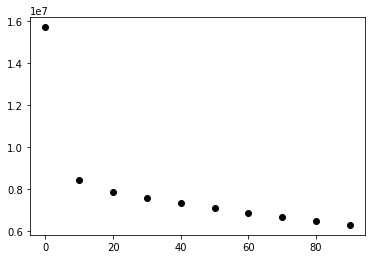

In [149]:
print("Coefficients: \n")
pp.pprint(thetas)

plot(itr_numbers, costs)

In [150]:
# MINI BATCH GRADIENT ALGORITHM

# Parameters
# Alpha
learningRate = 1e-03
# Number of cases in training
m = len(dataset_train)
# Thetas Vector
thetas = init_thetas(dataset_train)
# Number of iterations
max_iterations = 100000
iterations = 0
batch_size = 10

# Stop Conditions
stopCondition = 1e-03
done = False

# After j_step iterations, compute cost function
j_step = 1000
costs = []
itr_numbers = []


while(iterations < max_iterations and not done):
    
    # Step through the dataset in chuncks
    for row in range(0, len(dataset_train), batch_size):
        new_thetas = thetas.copy()
        
        # For each theta we do the following
        for k,val in thetas.items():

            s = 0
            # We add every row of the dataset to the error calculation (Batch)
            for offset in range(batch_size):
                if row + offset >= m:
                    break
                
                h = 0
                # Calculating the value for theta
                for i,v in thetas.items():
                    h += thetas[i] * dataset_train[row+offset][i]

                s += (h - float(target_train[row+offset])) * dataset_train[row+offset][k]

            # Updating the new thetas vector values
            new_thetas[k] = thetas[k] - ((learningRate / batch_size) * s)
        
        if iterations % j_step == 0:
            costs.append(calculate_cost_function(thetas, dataset_train, target_train))
            itr_numbers.append(iterations)
        
        iterations = iterations + 1
        if iterations >= max_iterations:
            break
            
        # If the change in value for new thetas is too small, we can stop iterating
        done = True
        for k,v in thetas.items():
            done = abs(thetas[k] - new_thetas[k]) < stopCondition and done
        if done:
            break

        # Atualization of the values of the thetas
        thetas = new_thetas.copy()
    
if iterations >= max_iterations:
    print("Stopped by number of iterations\n")
if done:
    print("Stopped by convergence\n")

Stopped by number of iterations



Coefficients: 

{   'carat': 13534.07583437853,
    'clarity': 1624.1025650352801,
    'color': 418.9193606712353,
    'cut': 441.67500339168475,
    'depth': 12.094002684467624,
    'table': -377.8970371043327,
    'x': 17429.218158906184,
    'x0': 8065.087500118445,
    'y': -115.75862554040087,
    'z': 417.2763627337401}


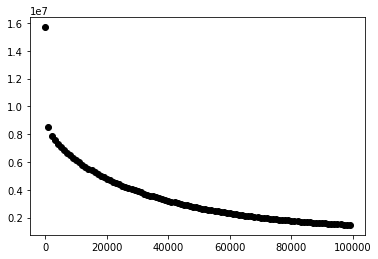

In [151]:
print("Coefficients: \n")
pp.pprint(thetas)

plot(itr_numbers, costs)

In [152]:
print(target_test[2])

teste = 0
for k,v in thetas.items():
    teste += thetas[k] * dataset_test[2][k]

print(teste)


6145
6976.413230140389
